# Implementation and test of PiNN over 8 free compartments of the test bolus model

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.special import gamma

In [1]:
## patient data: 
HU=31.74

patient1 = # Hidden 
patient2 = # Hidden
patient3 = # Hidden
patient4 = # Hidden
patient5 = # Hidden 
patient6 = # Hidden 

vref1 = # Hidden
vref2 = # Hidden
vref3 = # Hidden
vref4 = # Hidden
vref5 = # Hidden 
vref6 = # Hidden


qref1 = # Hidden 
qref2 = # Hidden 
qref3 = # Hidden 
qref4 = # Hidden 
qref5 = # Hidden  
qref6 = # Hidden 




SyntaxError: invalid syntax (326592568.py, line 3)

In [6]:
class Neural_net(torch.nn.Module):
    def __init__(self, n_in = 1, n_out =1):
        super(Neural_net, self).__init__()

        self.tanh = torch.nn.Tanh()

        self.layer1 = torch.nn.Linear(n_in,20)
        self.layer2 = torch.nn.Linear(20,20)
        self.layer3 = torch.nn.Linear(20,20)
        self.layer_out = torch.nn.Linear(20,n_out)

    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.layer2(x)
        x = self.tanh(x)
        x = self.layer3(x)
        x = self.tanh(x)
        x = self.layer_out(x)

        return x

In [7]:
class blood_8pinn:
    def __init__(self, epochs, data, nde= 100, gamma = False):
        self.epochs = epochs
        self.model = Neural_net(n_out=8)
        self.domain = torch.linspace(0,100, nde, requires_grad=True).reshape(-1,1)
        
        ###  Variable parameters
        self.s1_unconstr = torch.nn.Parameter(torch.tensor([1.]))
        self.s2_unconstr = torch.nn.Parameter(torch.tensor([1.]))
        
        # Adding parameters to model trainable variables
        self.model.register_parameter(name='s1_param', param = self.s1_unconstr)
        self.model.register_parameter(name='s2_param', param =self.s2_unconstr)

        ### Optimizers
        self.lbfgs_optimizer = torch.optim.LBFGS(params = self.model.parameters(), lr = 0.001,max_iter = 500)
        self.adam_optimizer = torch.optim.Adam(params = self.model.parameters(), lr = 0.001)

        #### Simulation Fixed parameters 
        patient_data, sim_data, vref , qref  = data
        self.pdat = patient_data
        
        self.Q_ref = qref
        self.Qinj_ref = 162/6500*self.Q_ref
        
        self.V_ref = torch.tensor(vref, dtype= torch.float)
        self.mc, self.qc =self.m_inj(np.linspace(0,100,nde))
        
        # self.Q = Q_ref + qc
        # self.Q_inj = Qinj + qc
        self.PS = 10
        
       
        ### Initialize data
        
              
        d_ids = np.arange(start=0, stop=len(sim_data[0]), step=len(sim_data[0])//nde)

        s_data ={}
        for i,d in enumerate(sim_data[1:]/HU):
            s_data[i] = torch.tensor(d[d_ids], dtype=torch.float).reshape(-1,1)

        self.maxes ={i:max(d) for i,d in s_data.items()}
        self.mins = {i:min(d) for i,d in s_data.items()}
       
        if gamma: ## Using a gamma variate fit of data at end-compartment instead of pure data-points
            popt, pcov = curve_fit(self.scaled_gamma, patient_data[0], patient_data[1], bounds = ((1000,1,1),(10000,10,10)))
            self.c_patient = torch.tensor(self.scaled_gamma(np.linspace(0,100,100),popt[0],popt[1], popt[2]), dtype=torch.float).reshape(-1,1)
            self.t_patient = torch.linspace(0,100,100).reshape(-1,1) 

        else:
            self.c_patient = torch.tensor(patient_data[1], dtype = torch.float).reshape(-1,1)
            self.t_patient = torch.tensor(patient_data[0], dtype=torch.float).reshape(-1,1) 

        self.c_patient_max = max(self.c_patient)
        self.c_patient_min = min(self.c_patient)
        self.c_patient_norm = (self.c_patient - self.c_patient_min)/(self.c_patient_max-self.c_patient_min) 


    #Constrain parameters to be in range
    @property
    def s1_param(self):
        return self.s1_unconstr

    @property
    def s2_param(self):
        return self.s2_unconstr

    def model_call(self,x):
        #return torch.abs(self.model(x))
        return self.model(x)

    #------------- Gamma variate 
    def scaled_gamma(self, x,c, k, theta):
            frac = 1/(gamma(k)*theta**(k))
            return c*frac*x**(k-1)*np.exp(-(x/theta))
    

    # ------------
    def m_inj(self, t,ti=[0,3.33,3.33,6.67,6.67],qi=[6,6,6,6,0],ci=[350,350,0,0,0]):
        ti=np.array(ti)
        qi=np.array(qi)
        ci=np.array(ci)
        m = qi*ci
        return torch.tensor(np.interp(t,ti,m), dtype=torch.float).reshape(-1,1), torch.tensor(np.interp(t,ti,qi), dtype = torch.float).reshape(-1,1)
    
    def normalize(self, id, unnormed):
        return (unnormed - self.mins[id])/(self.maxes[id]- self.mins[id])

    def un_normalize(self, id, normed):
        return normed*(self.maxes[id] -self.mins[id])+ self.mins[id]


    def wrap_grad(self, f,x):
        return torch.autograd.grad(f,x,
        grad_outputs=torch.ones_like(x),
        retain_graph=True,
        create_graph=True)[0]
        

    def de_loss(self):
        pred = self.model_call(self.domain)
        cs = [x.reshape(-1,1) for x in torch.unbind(pred, dim =1)]
        dcs =[self.wrap_grad(c, self.domain) for c in cs]
        cs_unnormed = [self.un_normalize(i,d) for i,d in enumerate(cs)]

        c0,c1,c2,c3,c4,c5,c6,c7 = cs_unnormed
        dc0,dc1,dc2,dc3,dc4,dc5,dc6,dc7 = dcs

        

        Q = self.Q_ref*self.s1_param+ self.qc
        Q_inj = 162/6500*self.Q_ref*self.s1_param + self.qc
        V = self.V_ref*self.s2_param

        z0 = dc0 - (self.mc -(Q_inj*c0))/(V[0]*(self.maxes[0]- self.mins[0]))
        z1 = dc1 - ((Q_inj)*c0-Q*c1)/(V[1]*(self.maxes[1]- self.mins[1]))   
        z2 = dc2 - (Q*c1-Q*c2)/(V[2]*(self.maxes[2]- self.mins[2]))
        z3 = dc3 - (Q*c2-Q*c3-self.PS*Q*(c3-c4))/(V[3]*(self.maxes[3]- self.mins[3]))
        z4 = dc4 - (self.PS*Q*(c3-c4))/(V[4]*(self.maxes[4]- self.mins[4]))
        z5 = dc5 - (Q*c3-Q*c5)/(V[5]*(self.maxes[5]- self.mins[5]))
        z6 = dc6 - (Q*c5-Q*c6)/(V[6]*(self.maxes[6]- self.mins[6]))
        z7 = dc7 - (Q*c6-Q*c7)/(V[7]*(self.maxes[7]- self.mins[7]))
         
        # z = (1/11111111)*(1e7*torch.mean(z0**2)+1e6*torch.mean(z1**2)+ 1e5*torch.mean(z2**2) + 1e4*torch.mean(z3**2) /
        #     1e3*torch.mean(z4**2) + 1e2*torch.mean(z5**2) + 1e1*torch.mean(z6**2) + 1e0*torch.mean(z7**2)) 

        weights = [1,1,1,1,1,1,1,1]
        
        zs = [torch.mean(z0**2), torch.mean(z1**2), torch.mean(z2**2) , torch.mean(z3**2) /
            torch.mean(z4**2) , torch.mean(z5**2) , torch.mean(z6**2) , torch.mean(z7**2)]

        z = sum([w*l for w,l in zip(zs,weights)])*(1/(sum(weights)))
        
        init_cond =  torch.mean(pred[0]**2)

        return init_cond + z


    def data_loss(self):
        c1,c2,c3,c4,c5,c6,c7,c8 = torch.unbind(self.model_call(self.t_patient), dim =1)
        return torch.mean((c8.reshape(-1,1) - self.c_patient_norm)**2)
    

    def combined_loss(self):
        return self.de_loss() + self.data_loss()

    
    def plot_preds(self):
        pred = self.model_call(self.domain)
        cs = [x for x in torch.unbind(pred, dim =1)]
        for i,c in enumerate(cs[1:]):
            plt.plot(self.domain.detach(),self.un_normalize(i+1,c.detach())*HU, label = f'c {i+2}')

        #plt.scatter(self.pdat[0], self.pdat[1])
        plt.grid()
        plt.legend()
    

    def lbfgs_train(self):
            self.model.train()    
            for epoch in range(self.epochs):
                def closure():
                    self.lbfgs_optimizer.zero_grad()
                    loss = self.combined_loss()
                    loss.backward()
                    return loss
                self.lbfgs_optimizer.step(closure=closure)
                print(f'Epoch {epoch}, training loss: {self.combined_loss()}')
            self.plot_preds()
    

    def adam_train(self):
            steps = 1000
            for epoch in range(self.epochs):
                for step in range(steps):
                    def closure():
                        self.adam_optimizer.zero_grad()
                        loss = self.combined_loss()
                        loss.backward()
                        return loss
                    self.adam_optimizer.step(closure=closure)
                print(f'Epoch {epoch}, training loss: {self.combined_loss()}, s1 {self.s1_param} S2: {self.s2_param}  Q: {self.Q_ref*self.s1_param*60}')
            self.plot_preds()

In [8]:
class b8_pinn_noparams(blood_8pinn):
    def __init__(self, epochs, data, nde= 100, gamma = False):
        super().__init__(epochs, data, nde= 100, gamma= gamma)
        self.const = torch.tensor([1.], dtype=torch.float)
    
    @property
    def s2_param(self):
        return self.const

    @property
    def s1_param(self):
        return self.const

class b8_pinn_sQ(blood_8pinn):
    def __init__(self, epochs, data, nde= 100, gamma = False):
        super().__init__(epochs, data, nde= 100, gamma = gamma)
        self.const = torch.tensor([1.], dtype=torch.float)

    @property
    def s1_param(self):
        return self.const

class b8_pinn_sV(blood_8pinn):
    def __init__(self, epochs, data, nde= 100, gamma = False):
        super().__init__(epochs, data, nde= 100, gamma = gamma)
        self.const = torch.tensor([1.], dtype=torch.float)
    
    @property
    def s2_param(self):
        return self.const


In [21]:
testdata = (patient4 ,p4_sim, vref4, qref4)

inst = blood_8pinn(epochs=20, data=testdata, gamma=False)

### Patient 1


In [9]:
p1data = (patient1, p1_sim, vref1, qref1)

print('Patient 1 s1, and s2')
p1_all_params= blood_8pinn(epochs=20, data = p1data)
p1_all_params.adam_train()



Patient 1 s1, and s2
Epoch 0, training loss: 0.057245831936597824, s1 Parameter containing:
tensor([0.4727], requires_grad=True) S2: Parameter containing:
tensor([1.4097], requires_grad=True)  Q: tensor([1994.1331], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.00891895592212677, s1 Parameter containing:
tensor([0.0170], requires_grad=True) S2: Parameter containing:
tensor([1.6299], requires_grad=True)  Q: tensor([71.8520], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.007994674146175385, s1 Parameter containing:
tensor([0.0005], requires_grad=True) S2: Parameter containing:
tensor([1.7686], requires_grad=True)  Q: tensor([1.9675], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.006278263870626688, s1 Parameter containing:
tensor([0.0003], requires_grad=True) S2: Parameter containing:
tensor([1.8836], requires_grad=True)  Q: tensor([1.1676], grad_fn=<MulBackward0>)


KeyboardInterrupt: 

Patient 1 s1, and s2, gamma fit
Epoch 0, training loss: 0.0013907277025282383, s1 Parameter containing:
tensor([0.4833], requires_grad=True) S2: Parameter containing:
tensor([1.4548], requires_grad=True)  Q: tensor([2038.8972], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.0006781163392588496, s1 Parameter containing:
tensor([0.3047], requires_grad=True) S2: Parameter containing:
tensor([1.6497], requires_grad=True)  Q: tensor([1285.4946], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0005171028897166252, s1 Parameter containing:
tensor([0.2102], requires_grad=True) S2: Parameter containing:
tensor([1.7975], requires_grad=True)  Q: tensor([886.6534], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.000447188998805359, s1 Parameter containing:
tensor([0.1707], requires_grad=True) S2: Parameter containing:
tensor([1.9388], requires_grad=True)  Q: tensor([720.3052], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.00040525582153350115, s1 Parameter containing:
tensor([0.1458], r

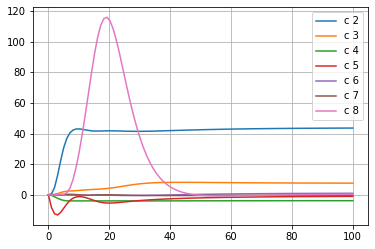

In [23]:
print('Patient 1 s1, and s2, gamma fit')
p1_all_params_gamma = blood_8pinn(epochs=20, data = p1data, gamma=True)
p1_all_params_gamma.adam_train()



Patient 1 s1
Epoch 0, training loss: 0.00941928755491972, s1 tensor([1.]) S2: Parameter containing:
tensor([1.4703], requires_grad=True)  Q: tensor([4218.6899])
Epoch 1, training loss: 0.004799281246960163, s1 tensor([1.]) S2: Parameter containing:
tensor([1.6886], requires_grad=True)  Q: tensor([4218.6899])
Epoch 2, training loss: 0.0026631327345967293, s1 tensor([1.]) S2: Parameter containing:
tensor([1.8835], requires_grad=True)  Q: tensor([4218.6899])
Epoch 3, training loss: 0.0013150576269254088, s1 tensor([1.]) S2: Parameter containing:
tensor([2.0904], requires_grad=True)  Q: tensor([4218.6899])
Epoch 4, training loss: 0.001023735385388136, s1 tensor([1.]) S2: Parameter containing:
tensor([2.2529], requires_grad=True)  Q: tensor([4218.6899])
Epoch 5, training loss: 0.0010850268881767988, s1 tensor([1.]) S2: Parameter containing:
tensor([2.4132], requires_grad=True)  Q: tensor([4218.6899])
Epoch 6, training loss: 0.0009275170159526169, s1 tensor([1.]) S2: Parameter containing:
te

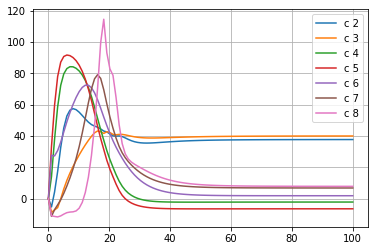

In [24]:
print('Patient 1 s1')
p1_sq = b8_pinn_sQ(epochs=20, data = p1data)
p1_sq.adam_train()



Patient 1 s1, gamma fit
Epoch 0, training loss: 0.004080438520759344, s1 tensor([1.]) S2: Parameter containing:
tensor([1.6107], requires_grad=True)  Q: tensor([4218.6899])
Epoch 1, training loss: 0.002119682263582945, s1 tensor([1.]) S2: Parameter containing:
tensor([1.9460], requires_grad=True)  Q: tensor([4218.6899])
Epoch 2, training loss: 0.0006487450446002185, s1 tensor([1.]) S2: Parameter containing:
tensor([2.2670], requires_grad=True)  Q: tensor([4218.6899])
Epoch 3, training loss: 0.0004457866889424622, s1 tensor([1.]) S2: Parameter containing:
tensor([2.4456], requires_grad=True)  Q: tensor([4218.6899])
Epoch 4, training loss: 0.00039946759352460504, s1 tensor([1.]) S2: Parameter containing:
tensor([2.6368], requires_grad=True)  Q: tensor([4218.6899])
Epoch 5, training loss: 0.00036236070445738733, s1 tensor([1.]) S2: Parameter containing:
tensor([2.8625], requires_grad=True)  Q: tensor([4218.6899])
Epoch 6, training loss: 0.0005618350114673376, s1 tensor([1.]) S2: Parameter

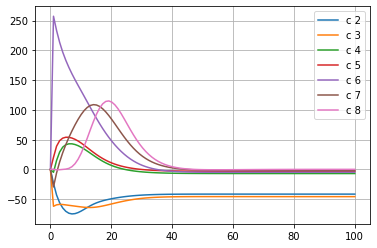

In [56]:
print('Patient 1 s1, gamma fit')
p1_sq_gamma = b8_pinn_sQ(epochs=20, data = p1data, gamma = True)
p1_sq_gamma.adam_train()



Patient 1, s2
Epoch 0, training loss: 0.06674457341432571, s1 Parameter containing:
tensor([0.4733], requires_grad=True) S2: tensor([1.])  Q: tensor([1996.8148], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.009642212651669979, s1 Parameter containing:
tensor([0.0034], requires_grad=True) S2: tensor([1.])  Q: tensor([14.1339], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.007953778840601444, s1 Parameter containing:
tensor([0.0022], requires_grad=True) S2: tensor([1.])  Q: tensor([9.4609], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0068017710000276566, s1 Parameter containing:
tensor([0.0010], requires_grad=True) S2: tensor([1.])  Q: tensor([4.3357], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.005938987247645855, s1 Parameter containing:
tensor([0.0005], requires_grad=True) S2: tensor([1.])  Q: tensor([2.2436], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.005274923983961344, s1 Parameter containing:
tensor([-0.0001], requires_grad=True) S2: tensor([1.])  Q: te

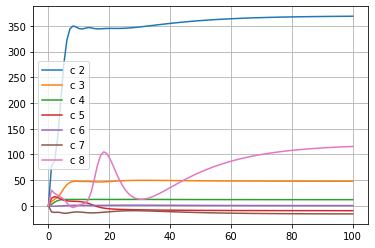

In [26]:
print('Patient 1, s2')
p1_sv = b8_pinn_sV(epochs=20, data = p1data)
p1_sv.adam_train()



patient 1, s2, gamma fit
Epoch 0, training loss: 0.0035412139259278774, s1 Parameter containing:
tensor([0.4187], requires_grad=True) S2: tensor([1.])  Q: tensor([1766.4779], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.0012465096078813076, s1 Parameter containing:
tensor([0.3154], requires_grad=True) S2: tensor([1.])  Q: tensor([1330.6420], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0008065981091931462, s1 Parameter containing:
tensor([0.2287], requires_grad=True) S2: tensor([1.])  Q: tensor([964.7634], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0006077138241380453, s1 Parameter containing:
tensor([0.1498], requires_grad=True) S2: tensor([1.])  Q: tensor([632.0889], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0004656804376281798, s1 Parameter containing:
tensor([0.0986], requires_grad=True) S2: tensor([1.])  Q: tensor([416.1043], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0003722386318258941, s1 Parameter containing:
tensor([0.0531], requires_grad=True)

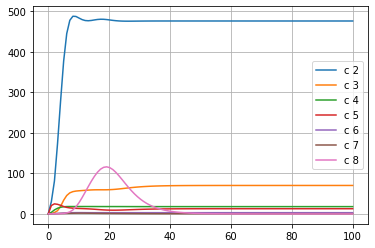

In [27]:
print('patient 1, s2, gamma fit')
p1_sv_gamma = b8_pinn_sV(epochs=20, data = p1data, gamma = True)
p1_sv_gamma.adam_train()


patient 1, no params


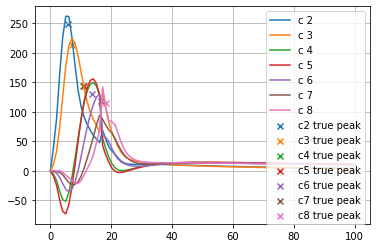

In [53]:

print('patient 1, no params')
# p1_none =b8_pinn_noparams(epochs=20, data = p1data)
#p1_none.adam_train()

p1_none.plot_preds()
t_ms = [p1_sim[0][np.argmax(c)] for c in p1_sim[1:]]
maxes =[max(c) for c in p1_sim[1:]]

d = 2
for i,p in zip(t_ms[1:], maxes[1:]):
    plt.scatter(i,p, marker='x', label =f'c{d} true peak')
    d+=1
plt.legend()


In [48]:
preds = p1_none.model_call(p1_none.domain).detach().numpy()


t_mspred = [preds.T[0][np.argmax(c)] for c in preds.T[1:]]
pred_maxes =[max(c) for c in preds.T[1:]]



patient 1 , no params, gamma fit
Epoch 0, training loss: 7.301801088033244e-05, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4218.6899])
Epoch 1, training loss: 7.25510180927813e-05, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4218.6899])
Epoch 2, training loss: 0.00010154844494536519, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4218.6899])
Epoch 3, training loss: 7.215439109131694e-05, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4218.6899])
Epoch 4, training loss: 7.665006705792621e-05, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4218.6899])
Epoch 5, training loss: 0.00018324784468859434, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4218.6899])
Epoch 6, training loss: 5.81024432904087e-05, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4218.6899])
Epoch 7, training loss: 0.0003153132274746895, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4218.6899])
Epoch 8, training loss: 0.00010780958837131038, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4218.6899])
Epoch 9, training loss: 6.5398

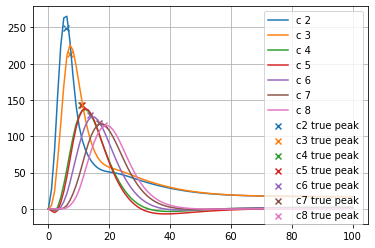

In [22]:
print('patient 1 , no params, gamma fit')
# p1_none_gamma = b8_pinn_noparams(epochs=20, data = p1data, gamma=True)
p1_none_gamma.adam_train()

#p1_none_gamma.plot_preds()

d = 2
for i,p in zip(t_ms[1:], maxes[1:]):
    plt.scatter(i,p, marker='x', label =f'c{d} true peak')
    d+=1
plt.legend()

### Patient 2

Patient 2 s1, and s2
Epoch 0, training loss: 0.024621406570076942, s1 tensor([1.5447], grad_fn=<AddBackward0>) S2: tensor([1.6810], grad_fn=<MulBackward0>)  Q: tensor([5427.0537], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.009349429979920387, s1 tensor([1.4276], grad_fn=<AddBackward0>) S2: tensor([1.7494], grad_fn=<MulBackward0>)  Q: tensor([5015.7358], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.003370045917108655, s1 tensor([1.3191], grad_fn=<AddBackward0>) S2: tensor([1.8013], grad_fn=<MulBackward0>)  Q: tensor([4634.3916], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0008064198773354292, s1 tensor([1.2584], grad_fn=<AddBackward0>) S2: tensor([1.8316], grad_fn=<MulBackward0>)  Q: tensor([4421.3516], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0005238644662313163, s1 tensor([1.2205], grad_fn=<AddBackward0>) S2: tensor([1.8526], grad_fn=<MulBackward0>)  Q: tensor([4287.8691], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0004533177416305989, s1 tensor([1.19

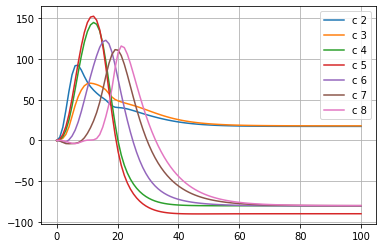

In [28]:
p2data = (patient2, p2_sim, vref2, qref2)

#1
print('Patient 2 s1, and s2')
p2_all_params= blood_8pinn(epochs=20, data = p2data)
p2_all_params.adam_train()

Patient 2 s1, and s2, gamma fit
Epoch 0, training loss: 0.003074170555919409, s1 tensor([1.5979], grad_fn=<AddBackward0>) S2: tensor([1.6495], grad_fn=<MulBackward0>)  Q: tensor([5613.8730], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.0010487285908311605, s1 tensor([1.5108], grad_fn=<AddBackward0>) S2: tensor([1.7197], grad_fn=<MulBackward0>)  Q: tensor([5308.1431], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0007508051348850131, s1 tensor([1.4096], grad_fn=<AddBackward0>) S2: tensor([1.7742], grad_fn=<MulBackward0>)  Q: tensor([4952.3486], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0005861448589712381, s1 tensor([1.3047], grad_fn=<AddBackward0>) S2: tensor([1.8203], grad_fn=<MulBackward0>)  Q: tensor([4584.0044], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0005428432486951351, s1 tensor([1.2208], grad_fn=<AddBackward0>) S2: tensor([1.8568], grad_fn=<MulBackward0>)  Q: tensor([4289.0063], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0006097655277699232, s1

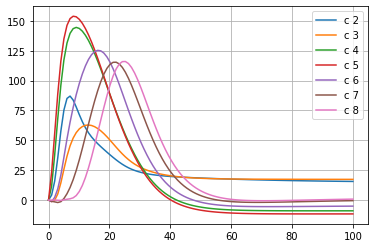

In [29]:
#2
print('Patient 2 s1, and s2, gamma fit')
p2_all_params_gamma = blood_8pinn(epochs=20, data = p2data, gamma=True)
p2_all_params_gamma.adam_train()

Patient 2 s1
Epoch 0, training loss: 0.02230718545615673, s1 tensor([1.]) S2: tensor([1.6715], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 1, training loss: 0.0012440821155905724, s1 tensor([1.]) S2: tensor([1.7460], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 2, training loss: 0.0006934271077625453, s1 tensor([1.]) S2: tensor([1.7942], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 3, training loss: 0.001258875709027052, s1 tensor([1.]) S2: tensor([1.8305], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 4, training loss: 0.0008373816963285208, s1 tensor([1.]) S2: tensor([1.8627], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 5, training loss: 0.0004551192687358707, s1 tensor([1.]) S2: tensor([1.8899], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 6, training loss: 0.00041970962774939835, s1 tensor([1.]) S2: tensor([1.9117], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 7, training loss: 0.000389785913284868, s1 tensor([1.]) S2:

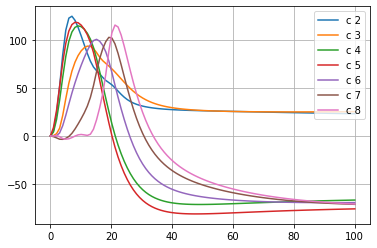

In [30]:
#3
print('Patient 2 s1')
p2_sq = b8_pinn_sQ(epochs=20, data = p2data)
p2_sq.adam_train()

Patient 2 s1, gamma fit
Epoch 0, training loss: 0.013818956911563873, s1 tensor([1.]) S2: tensor([1.6696], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 1, training loss: 0.003318716073408723, s1 tensor([1.]) S2: tensor([1.7781], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 2, training loss: 0.0020204181782901287, s1 tensor([1.]) S2: tensor([1.8290], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 3, training loss: 0.0015111751854419708, s1 tensor([1.]) S2: tensor([1.8620], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 4, training loss: 0.0015246749389916658, s1 tensor([1.]) S2: tensor([1.8886], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 5, training loss: 0.001145087298937142, s1 tensor([1.]) S2: tensor([1.9138], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 6, training loss: 0.0010831477120518684, s1 tensor([1.]) S2: tensor([1.9360], grad_fn=<MulBackward0>)  Q: tensor([3513.3499])
Epoch 7, training loss: 0.001177133060991764, s1 tensor

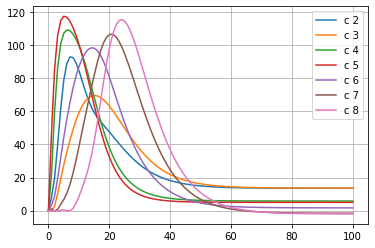

In [31]:
#4
print('Patient 2 s1, gamma fit')
p2_sq_gamma = b8_pinn_sQ(epochs=20, data = p2data, gamma = True)
p2_sq_gamma.adam_train()


Patient 2, s2
Epoch 0, training loss: 0.024661580100655556, s1 tensor([1.6009], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5624.5913], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.005137722939252853, s1 tensor([1.5513], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5450.1060], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0018319152295589447, s1 tensor([1.4185], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4983.5615], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0012842806754633784, s1 tensor([1.3253], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4656.2256], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0009586497908458114, s1 tensor([1.2630], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4437.5352], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.000840435444843024, s1 tensor([1.2075], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4242.2700], grad_fn=<MulBackward0>)
Epoch 6, training loss: 0.000643824168946594, s1 tens

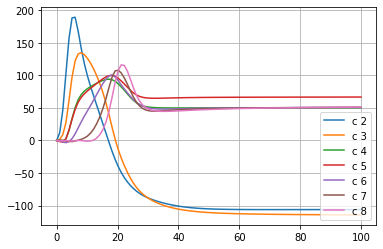

In [32]:
#5
print('Patient 2, s2')
p2_sv = b8_pinn_sV(epochs=20, data = p2data)
p2_sv.adam_train()


patient 2, s2, gamma fit
Epoch 0, training loss: 0.0025977694895118475, s1 tensor([1.6135], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5668.7012], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.00153001316357404, s1 tensor([1.4654], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5148.6152], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.001159709063358605, s1 tensor([1.3124], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4610.9448], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0009665441466495395, s1 tensor([1.1980], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4208.8315], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.001268408028408885, s1 tensor([1.1263], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([3957.2366], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0006440907018259168, s1 tensor([1.0826], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([3803.4609], grad_fn=<MulBackward0>)
Epoch 6, training loss: 0.00069537782110273

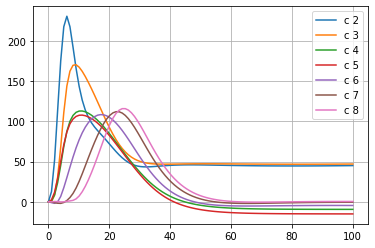

In [33]:
#6
print('patient 2, s2, gamma fit')
p2_sv_gamma = b8_pinn_sV(epochs=20, data = p2data, gamma = True)
p2_sv_gamma.adam_train()

patient 2, no params
Epoch 0, training loss: 0.023101693019270897, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 1, training loss: 0.0013339072465896606, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 2, training loss: 0.0011499752290546894, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 3, training loss: 0.0008696704753674567, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 4, training loss: 0.0008077077800408006, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 5, training loss: 0.0006678335485048592, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 6, training loss: 0.0006172377616167068, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 7, training loss: 0.000554534315597266, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 8, training loss: 0.0004986602580174804, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 9, training loss: 0.0007506239926442504

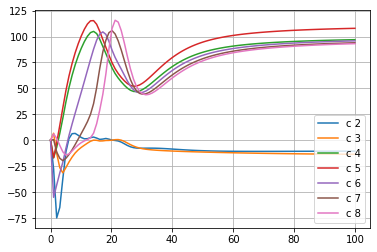

In [34]:
#7
print('patient 2, no params')
p2_none =b8_pinn_noparams(epochs=20, data = p2data)
p2_none.adam_train()


patient 2 , no params, gamma fit
Epoch 0, training loss: 0.002028238493949175, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 1, training loss: 0.0014702496118843555, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 2, training loss: 0.000917755882255733, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 3, training loss: 0.0007586394203826785, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 4, training loss: 0.0010163955157622695, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 5, training loss: 0.000584018009249121, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 6, training loss: 0.00027526626945473254, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 7, training loss: 0.00040814600652083755, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 8, training loss: 0.00018030847422778606, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3513.3499])
Epoch 9, training loss: 0.00023

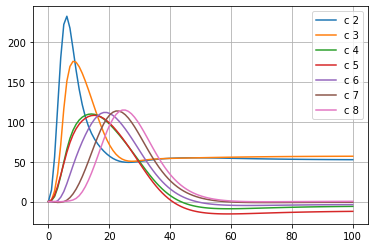

In [35]:
#8
print('patient 2 , no params, gamma fit')
p2_none_gamma = b8_pinn_noparams(epochs=20, data = p2data, gamma=True)
p2_none_gamma.adam_train()


### Patient 3

Patient 3 s1, and s2
Epoch 0, training loss: 0.03868681564927101, s1 tensor([1.5300], grad_fn=<AddBackward0>) S2: tensor([1.6874], grad_fn=<MulBackward0>)  Q: tensor([6594.9521], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.005964924581348896, s1 tensor([1.3830], grad_fn=<AddBackward0>) S2: tensor([1.7707], grad_fn=<MulBackward0>)  Q: tensor([5961.2495], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0022845244966447353, s1 tensor([1.2953], grad_fn=<AddBackward0>) S2: tensor([1.8128], grad_fn=<MulBackward0>)  Q: tensor([5583.5454], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.001645456999540329, s1 tensor([1.2406], grad_fn=<AddBackward0>) S2: tensor([1.8403], grad_fn=<MulBackward0>)  Q: tensor([5347.4575], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0018631061539053917, s1 tensor([1.1893], grad_fn=<AddBackward0>) S2: tensor([1.8667], grad_fn=<MulBackward0>)  Q: tensor([5126.7031], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0015001555439084768, s1 tensor([1.141

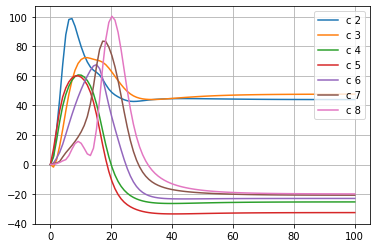

In [36]:
p3data = (patient3, p3_sim, vref3, qref3)

#1
print('Patient 3 s1, and s2')
p3_all_params= blood_8pinn(epochs=20, data = p3data)
p3_all_params.adam_train()

Patient 3 s1, and s2, gamma fit
Epoch 0, training loss: 0.002762202173471451, s1 tensor([1.6250], grad_fn=<AddBackward0>) S2: tensor([1.6206], grad_fn=<MulBackward0>)  Q: tensor([7004.4053], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.0012197484029456973, s1 tensor([1.5194], grad_fn=<AddBackward0>) S2: tensor([1.7028], grad_fn=<MulBackward0>)  Q: tensor([6549.6143], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.001065596123225987, s1 tensor([1.3690], grad_fn=<AddBackward0>) S2: tensor([1.7767], grad_fn=<MulBackward0>)  Q: tensor([5901.2476], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0006202273070812225, s1 tensor([1.2712], grad_fn=<AddBackward0>) S2: tensor([1.8231], grad_fn=<MulBackward0>)  Q: tensor([5479.6401], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0013388384832069278, s1 tensor([1.2149], grad_fn=<AddBackward0>) S2: tensor([1.8538], grad_fn=<MulBackward0>)  Q: tensor([5237.0205], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.00034156942274421453, s1

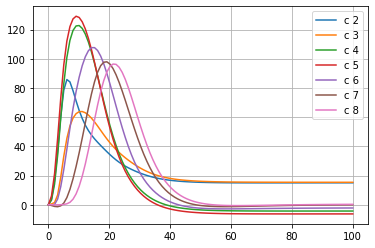

In [37]:
#2
print('Patient 3 s1, and s2, gamma fit')
p3_all_params_gamma = blood_8pinn(epochs=20, data = p3data, gamma=True)
p3_all_params_gamma.adam_train()

Patient 3 s1
Epoch 0, training loss: 0.04504325985908508, s1 tensor([1.]) S2: tensor([1.6957], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 1, training loss: 0.003892912296578288, s1 tensor([1.]) S2: tensor([1.7987], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 2, training loss: 0.0017685184720903635, s1 tensor([1.]) S2: tensor([1.8491], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 3, training loss: 0.0014283476630225778, s1 tensor([1.]) S2: tensor([1.8762], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 4, training loss: 0.0013020167825743556, s1 tensor([1.]) S2: tensor([1.8981], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 5, training loss: 0.0013841036707162857, s1 tensor([1.]) S2: tensor([1.9173], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 6, training loss: 0.0012308184523135424, s1 tensor([1.]) S2: tensor([1.9336], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 7, training loss: 0.0011876738863065839, s1 tensor([1.]) S2:

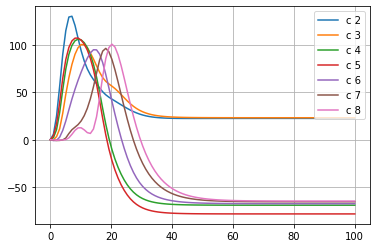

In [38]:
#3
print('Patient 3 s1')
p3_sq = b8_pinn_sQ(epochs=20, data = p3data)
p3_sq.adam_train()

Patient 3 s1, gamma fit
Epoch 0, training loss: 0.0016111030708998442, s1 tensor([1.]) S2: tensor([1.5620], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 1, training loss: 0.0006599575281143188, s1 tensor([1.]) S2: tensor([1.6361], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 2, training loss: 0.0006627927650697529, s1 tensor([1.]) S2: tensor([1.7088], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 3, training loss: 0.0004716016701422632, s1 tensor([1.]) S2: tensor([1.7733], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 4, training loss: 0.0004027905815746635, s1 tensor([1.]) S2: tensor([1.8260], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 5, training loss: 0.00039131156518124044, s1 tensor([1.]) S2: tensor([1.8662], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 6, training loss: 0.00029665991314686835, s1 tensor([1.]) S2: tensor([1.8950], grad_fn=<MulBackward0>)  Q: tensor([4310.5200])
Epoch 7, training loss: 0.00023535912623628974, s1

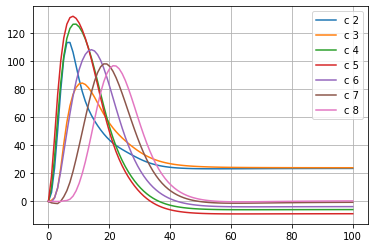

In [39]:
#4
print('Patient 3 s1, gamma fit')
p3_sq_gamma = b8_pinn_sQ(epochs=20, data = p3data, gamma = True)
p3_sq_gamma.adam_train()


Patient 3, s2
Epoch 0, training loss: 0.0447843112051487, s1 tensor([1.6520], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([7120.8594], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.010087579488754272, s1 tensor([1.4675], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([6325.6509], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.003821569960564375, s1 tensor([1.2749], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5495.4497], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.002309391973540187, s1 tensor([1.1872], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5117.5747], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0016426134388893843, s1 tensor([1.1411], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4918.9395], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.001354781212285161, s1 tensor([1.1108], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4788.2935], grad_fn=<MulBackward0>)
Epoch 6, training loss: 0.0012113696429878473, s1 tensor(

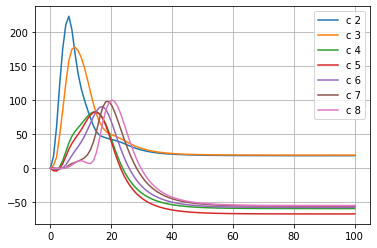

In [40]:
#5
print('Patient 3, s2')
p3_sv = b8_pinn_sV(epochs=20, data = p3data)
p3_sv.adam_train()

patient 3, s2, gamma fit
Epoch 0, training loss: 0.0034416797570884228, s1 tensor([1.5450], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([6659.7124], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.0020432991441339254, s1 tensor([1.3648], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5883.0908], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0012594269355759025, s1 tensor([1.2352], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5324.2822], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0007565338746644557, s1 tensor([1.1593], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4997.0093], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0005217645666562021, s1 tensor([1.1104], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4786.5420], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.00040166120743378997, s1 tensor([1.0755], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4635.7964], grad_fn=<MulBackward0>)
Epoch 6, training loss: 0.000314151431

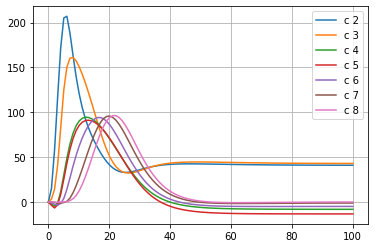

In [41]:
#6
print('patient 3, s2, gamma fit')
p3_sv_gamma = b8_pinn_sV(epochs=20, data = p3data, gamma = True)
p3_sv_gamma.adam_train()

patient 3, no params
Epoch 0, training loss: 0.04507630690932274, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 1, training loss: 0.007231557741761208, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 2, training loss: 0.0033862022683024406, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 3, training loss: 0.002265047747641802, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 4, training loss: 0.0019143400713801384, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 5, training loss: 0.002587237162515521, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 6, training loss: 0.001353515195660293, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 7, training loss: 0.0013435289729386568, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 8, training loss: 0.0017514564096927643, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 9, training loss: 0.0011136914836242795, s1

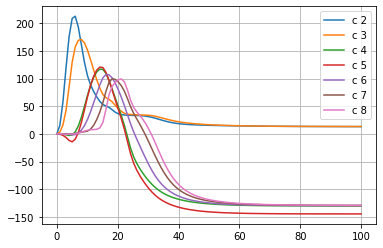

In [42]:
#7
print('patient 3, no params')
p3_none =b8_pinn_noparams(epochs=20, data = p3data)
p3_none.adam_train()


patient 3 , no params, gamma fit
Epoch 0, training loss: 0.0018424778245389462, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 1, training loss: 0.0011639841832220554, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 2, training loss: 0.0008160151191987097, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 3, training loss: 0.0013114232569932938, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 4, training loss: 0.000495316693559289, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 5, training loss: 0.0004030561540275812, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 6, training loss: 0.0002798938367050141, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 7, training loss: 0.00027922465233132243, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 8, training loss: 0.00025423525949008763, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4310.5200])
Epoch 9, training loss: 0.0010

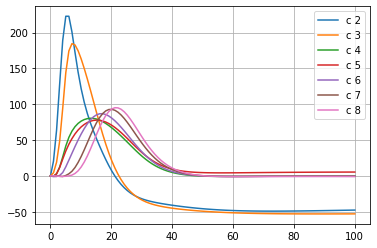

In [43]:
#8
print('patient 3 , no params, gamma fit')
p3_none_gamma = b8_pinn_noparams(epochs=20, data = p3data, gamma=True)
p3_none_gamma.adam_train()


### Patient 4

Patient 4 s1, and s2
Epoch 0, training loss: 0.008506851270794868, s1 tensor([1.6592], grad_fn=<AddBackward0>) S2: tensor([1.5792], grad_fn=<MulBackward0>)  Q: tensor([7484.5244], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.00268586166203022, s1 tensor([1.5916], grad_fn=<AddBackward0>) S2: tensor([1.6458], grad_fn=<MulBackward0>)  Q: tensor([7179.2832], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.001556097879074514, s1 tensor([1.4759], grad_fn=<AddBackward0>) S2: tensor([1.7181], grad_fn=<MulBackward0>)  Q: tensor([6657.6973], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0012772046029567719, s1 tensor([1.4412], grad_fn=<AddBackward0>) S2: tensor([1.7414], grad_fn=<MulBackward0>)  Q: tensor([6501.1230], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0009455347317270935, s1 tensor([1.4040], grad_fn=<AddBackward0>) S2: tensor([1.7665], grad_fn=<MulBackward0>)  Q: tensor([6333.1084], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0008129958296194673, s1 tensor([1.361

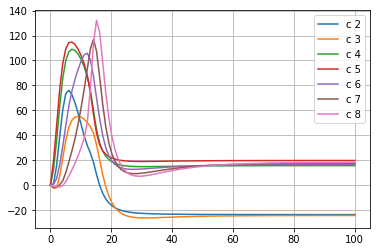

In [44]:
p4data = (patient4, p4_sim, vref4, qref4)

#1
print('Patient 4 s1, and s2')
p4_all_params= blood_8pinn(epochs=20, data = p4data)
p4_all_params.adam_train()

Patient 4 s1, and s2, gamma fit
Epoch 0, training loss: 0.0036407022271305323, s1 tensor([1.6013], grad_fn=<AddBackward0>) S2: tensor([1.6312], grad_fn=<MulBackward0>)  Q: tensor([7223.2197], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.0013899172190576792, s1 tensor([1.5040], grad_fn=<AddBackward0>) S2: tensor([1.7030], grad_fn=<MulBackward0>)  Q: tensor([6784.4575], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0010641309199854732, s1 tensor([1.3934], grad_fn=<AddBackward0>) S2: tensor([1.7616], grad_fn=<MulBackward0>)  Q: tensor([6285.5615], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0008320577908307314, s1 tensor([1.2794], grad_fn=<AddBackward0>) S2: tensor([1.8114], grad_fn=<MulBackward0>)  Q: tensor([5771.3623], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0007070177234709263, s1 tensor([1.1879], grad_fn=<AddBackward0>) S2: tensor([1.8521], grad_fn=<MulBackward0>)  Q: tensor([5358.4023], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0006340512190945446, s

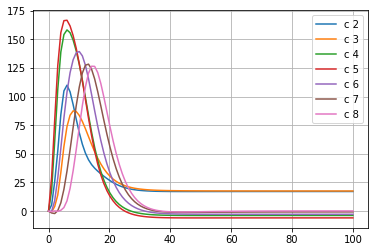

In [45]:
#2
print('Patient 4 s1, and s2, gamma fit')
p4_all_params_gamma = blood_8pinn(epochs=20, data = p4data, gamma=True)
p4_all_params_gamma.adam_train()

Patient 4 s1
Epoch 0, training loss: 0.009873013012111187, s1 tensor([1.]) S2: tensor([1.7022], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 1, training loss: 0.0025333045050501823, s1 tensor([1.]) S2: tensor([1.7694], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 2, training loss: 0.0012691617012023926, s1 tensor([1.]) S2: tensor([1.8070], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 3, training loss: 0.0010521765798330307, s1 tensor([1.]) S2: tensor([1.8428], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 4, training loss: 0.000842434645164758, s1 tensor([1.]) S2: tensor([1.8752], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 5, training loss: 0.0007497662445530295, s1 tensor([1.]) S2: tensor([1.9021], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 6, training loss: 0.0006959582678973675, s1 tensor([1.]) S2: tensor([1.9233], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 7, training loss: 0.000789100828114897, s1 tensor([1.]) S2:

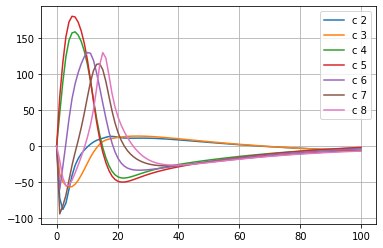

In [46]:
#3
print('Patient 4 s1')
p4_sq = b8_pinn_sQ(epochs=20, data = p4data)
p4_sq.adam_train()

Patient 4 s1, gamma fit
Epoch 0, training loss: 0.00302327168174088, s1 tensor([1.]) S2: tensor([1.6465], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 1, training loss: 0.001012041699141264, s1 tensor([1.]) S2: tensor([1.7254], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 2, training loss: 0.000761724601034075, s1 tensor([1.]) S2: tensor([1.7888], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 3, training loss: 0.0007316442206501961, s1 tensor([1.]) S2: tensor([1.8390], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 4, training loss: 0.0010004938812926412, s1 tensor([1.]) S2: tensor([1.8781], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 5, training loss: 0.0006468016654253006, s1 tensor([1.]) S2: tensor([1.9072], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 6, training loss: 0.00048198809963651, s1 tensor([1.]) S2: tensor([1.9283], grad_fn=<MulBackward0>)  Q: tensor([4510.8501])
Epoch 7, training loss: 0.0004043443768750876, s1 tensor([

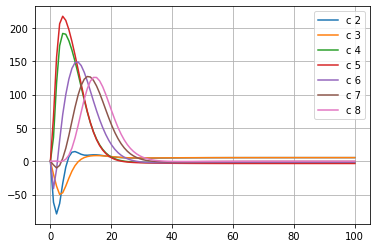

In [47]:
#4
print('Patient 4 s1, gamma fit')
p4_sq_gamma = b8_pinn_sQ(epochs=20, data = p4data, gamma = True)
p4_sq_gamma.adam_train()


Patient 4, s2
Epoch 0, training loss: 0.010291043668985367, s1 tensor([1.5688], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([7076.6040], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.0057161711156368256, s1 tensor([1.4265], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([6434.6133], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.003955851309001446, s1 tensor([1.3300], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5999.6001], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0024298341013491154, s1 tensor([1.2745], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5748.9185], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0015418649418279529, s1 tensor([1.2411], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5598.4478], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0010477472096681595, s1 tensor([1.2013], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5419.0098], grad_fn=<MulBackward0>)
Epoch 6, training loss: 0.0009087867802008986, s1 te

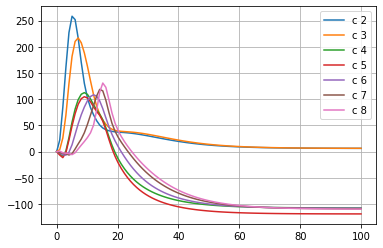

In [48]:
#5
print('Patient 4, s2')
p4_sv = b8_pinn_sV(epochs=20, data = p4data)
p4_sv.adam_train()

patient 4, s2, gamma fit
Epoch 0, training loss: 0.0032370053231716156, s1 tensor([1.6038], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([7234.4844], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.001207762281410396, s1 tensor([1.4967], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([6751.3135], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0008056032238528132, s1 tensor([1.4071], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([6347.2227], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.001038791611790657, s1 tensor([1.3299], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5999.1064], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0006245730328373611, s1 tensor([1.2654], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5708.1050], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0003696517669595778, s1 tensor([1.2110], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5462.7056], grad_fn=<MulBackward0>)
Epoch 6, training loss: 0.000406612030928

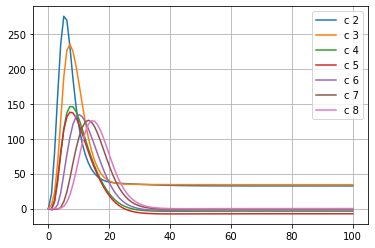

In [49]:
#6
print('patient 4, s2, gamma fit')
p4_sv_gamma = b8_pinn_sV(epochs=20, data = p4data, gamma = True)
p4_sv_gamma.adam_train()

patient 4, no params
Epoch 0, training loss: 0.07984104007482529, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 1, training loss: 0.07705901563167572, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 2, training loss: 0.0763714388012886, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 3, training loss: 0.07521867007017136, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 4, training loss: 0.020723974332213402, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 5, training loss: 0.005733141675591469, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 6, training loss: 0.004691164940595627, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 7, training loss: 0.004698665346950293, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 8, training loss: 0.0036839181557297707, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 9, training loss: 0.0035540414974093437, s1 tensor

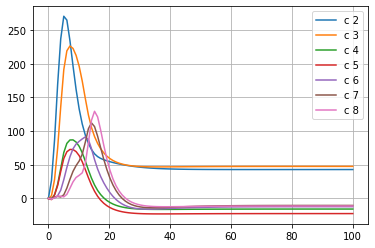

In [50]:
#7
print('patient 4, no params')
p4_none =b8_pinn_noparams(epochs=20, data = p4data)
p4_none.adam_train()

patient 4 , no params, gamma fit
Epoch 0, training loss: 0.003422618145123124, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 1, training loss: 0.0023490276653319597, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 2, training loss: 0.0014787608524784446, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 3, training loss: 0.0011525946902111173, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 4, training loss: 0.0012619269546121359, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 5, training loss: 0.0004913973971270025, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 6, training loss: 0.0003468813083600253, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 7, training loss: 0.0002724890364333987, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 8, training loss: 0.00023554438666906208, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([4510.8501])
Epoch 9, training loss: 0.00021

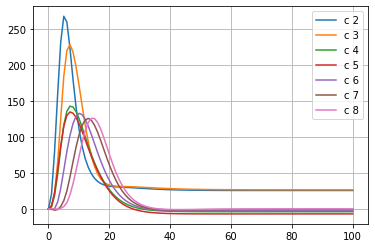

In [51]:
#8
print('patient 4 , no params, gamma fit')
p4_none_gamma = b8_pinn_noparams(epochs=20, data = p4data, gamma=True)
p4_none_gamma.adam_train()

### Patient 5

Patient 5 s1, and s2
Epoch 0, training loss: 0.02030346542596817, s1 tensor([1.5393], grad_fn=<AddBackward0>) S2: tensor([1.6797], grad_fn=<MulBackward0>)  Q: tensor([4778.3701], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.01631513237953186, s1 tensor([1.4450], grad_fn=<AddBackward0>) S2: tensor([1.7388], grad_fn=<MulBackward0>)  Q: tensor([4485.6465], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.012550214305520058, s1 tensor([1.3765], grad_fn=<AddBackward0>) S2: tensor([1.7779], grad_fn=<MulBackward0>)  Q: tensor([4273.0444], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0075387670658528805, s1 tensor([1.2736], grad_fn=<AddBackward0>) S2: tensor([1.8257], grad_fn=<MulBackward0>)  Q: tensor([3953.5959], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0028229353483766317, s1 tensor([1.1639], grad_fn=<AddBackward0>) S2: tensor([1.8744], grad_fn=<MulBackward0>)  Q: tensor([3613.1208], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0011423469986766577, s1 tensor([1.1090

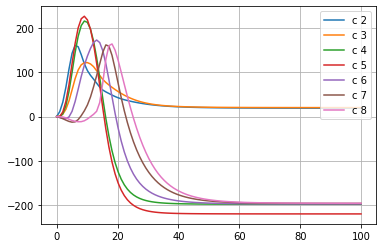

In [52]:
p5data = (patient5, p5_sim, vref5, qref5)

#1
print('Patient 5 s1, and s2')
p5_all_params= blood_8pinn(epochs=20, data = p5data)
p5_all_params.adam_train()

Patient 5 s1, and s2, gamma fit
Epoch 0, training loss: 0.0991179421544075, s1 tensor([1.5820], grad_fn=<AddBackward0>) S2: tensor([1.6527], grad_fn=<MulBackward0>)  Q: tensor([4911.0620], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.09783875197172165, s1 tensor([1.4331], grad_fn=<AddBackward0>) S2: tensor([1.7474], grad_fn=<MulBackward0>)  Q: tensor([4448.9756], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.004838207270950079, s1 tensor([1.2840], grad_fn=<AddBackward0>) S2: tensor([1.8160], grad_fn=<MulBackward0>)  Q: tensor([3986.0293], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0013190789613872766, s1 tensor([1.1832], grad_fn=<AddBackward0>) S2: tensor([1.8643], grad_fn=<MulBackward0>)  Q: tensor([3673.0671], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0008882961119525135, s1 tensor([1.1281], grad_fn=<AddBackward0>) S2: tensor([1.8953], grad_fn=<MulBackward0>)  Q: tensor([3502.1101], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.000758475624024868, s1 tenso

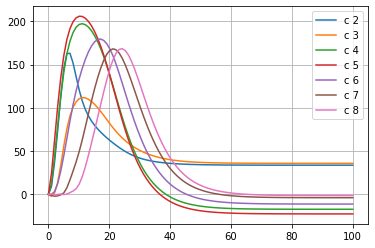

In [53]:
#2
print('Patient 5 s1, and s2, gamma fit')
p5_all_params_gamma = blood_8pinn(epochs=20, data = p5data, gamma=True)
p5_all_params_gamma.adam_train()

Patient 5 s1
Epoch 0, training loss: 0.028977468609809875, s1 tensor([1.]) S2: tensor([1.6140], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 1, training loss: 0.01879333332180977, s1 tensor([1.]) S2: tensor([1.7635], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 2, training loss: 0.016247445717453957, s1 tensor([1.]) S2: tensor([1.8128], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 3, training loss: 0.007750567980110645, s1 tensor([1.]) S2: tensor([1.8298], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 4, training loss: 0.0009028319036588073, s1 tensor([1.]) S2: tensor([1.8517], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 5, training loss: 0.0005783257656730711, s1 tensor([1.]) S2: tensor([1.8710], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 6, training loss: 0.0004979199729859829, s1 tensor([1.]) S2: tensor([1.8890], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 7, training loss: 0.0007510242867283523, s1 tensor([1.]) S2: t

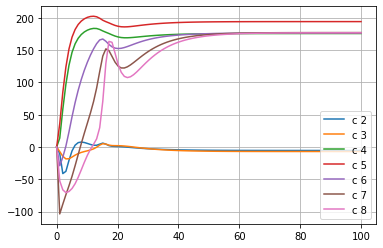

In [54]:
#3
print('Patient 5 s1')
p5_sq = b8_pinn_sQ(epochs=20, data = p5data)
p5_sq.adam_train()

Patient 5 s1, gamma fit
Epoch 0, training loss: 0.003661746857687831, s1 tensor([1.]) S2: tensor([1.6662], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 1, training loss: 0.0014694579876959324, s1 tensor([1.]) S2: tensor([1.7401], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 2, training loss: 0.0009377808892168105, s1 tensor([1.]) S2: tensor([1.7958], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 3, training loss: 0.0015731914900243282, s1 tensor([1.]) S2: tensor([1.8819], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 4, training loss: 0.0006237250636331737, s1 tensor([1.]) S2: tensor([1.9105], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 5, training loss: 0.0005233731353655457, s1 tensor([1.]) S2: tensor([1.9283], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 6, training loss: 0.0005711487028747797, s1 tensor([1.]) S2: tensor([1.9440], grad_fn=<MulBackward0>)  Q: tensor([3104.3398])
Epoch 7, training loss: 0.00044173351489007473, s1 te

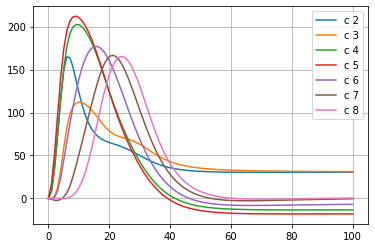

In [55]:
#4
print('Patient 5 s1, gamma fit')
p5_sq_gamma = b8_pinn_sQ(epochs=20, data = p5data, gamma = True)
p5_sq_gamma.adam_train()

Patient 5, s2
Epoch 0, training loss: 0.036174751818180084, s1 tensor([1.5157], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4705.3115], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.02089845947921276, s1 tensor([1.3575], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4214.2266], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.01208975538611412, s1 tensor([1.2449], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([3864.4624], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0036704768426716328, s1 tensor([1.2080], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([3749.8879], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.001479149330407381, s1 tensor([1.1842], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([3676.2871], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0011140051065012813, s1 tensor([1.1616], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([3606.0601], grad_fn=<MulBackward0>)
Epoch 6, training loss: 0.0013772188685834408, s1 tensor

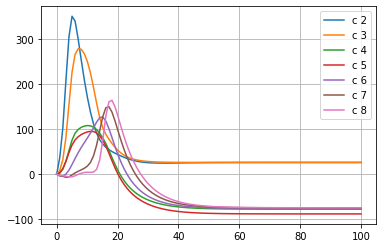

In [56]:
#5
print('Patient 5, s2')
p5_sv = b8_pinn_sV(epochs=20, data = p5data)
p5_sv.adam_train()

patient 5, s2, gamma fit
Epoch 0, training loss: 0.09789135307073593, s1 tensor([1.6435], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5101.8887], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.0979529395699501, s1 tensor([1.5435], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4791.5215], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0017635852564126253, s1 tensor([1.3568], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4212.0908], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.001035993336699903, s1 tensor([1.2605], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([3913.0503], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0011652861721813679, s1 tensor([1.2033], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([3735.4602], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0008378670900128782, s1 tensor([1.1424], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([3546.5134], grad_fn=<MulBackward0>)
Epoch 6, training loss: 0.0004434126312844455

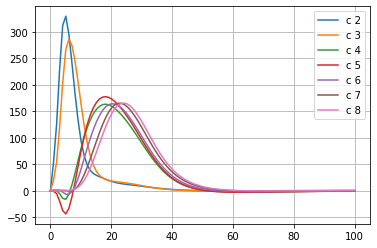

In [57]:
#6
print('patient 5, s2, gamma fit')
p5_sv_gamma = b8_pinn_sV(epochs=20, data = p5data, gamma = True)
p5_sv_gamma.adam_train()

patient 5, no params
Epoch 0, training loss: 0.020143626257777214, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 1, training loss: 0.012831563130021095, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 2, training loss: 0.0016752847004681826, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 3, training loss: 0.0013386855134740472, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 4, training loss: 0.0007875064620748162, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 5, training loss: 0.0006608345429413021, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 6, training loss: 0.0005677295848727226, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 7, training loss: 0.0005110337515361607, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 8, training loss: 0.0004865756200160831, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 9, training loss: 0.0004268344200681895

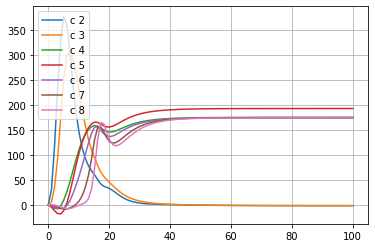

In [58]:
#7
print('patient 5, no params')
p5_none =b8_pinn_noparams(epochs=20, data = p5data)
p5_none.adam_train()

patient 5 , no params, gamma fit
Epoch 0, training loss: 0.003907082602381706, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 1, training loss: 0.0014271065592765808, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 2, training loss: 0.001138382125645876, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 3, training loss: 0.000887883419636637, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 4, training loss: 0.0006064933259040117, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 5, training loss: 0.0005116748507134616, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 6, training loss: 0.0003905824851244688, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 7, training loss: 0.00029294504201970994, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 8, training loss: 0.0002505301672499627, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3104.3398])
Epoch 9, training loss: 0.0002006

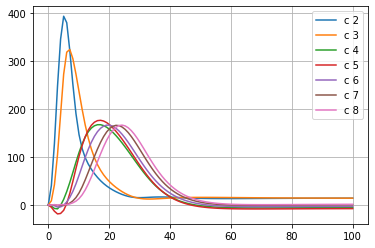

In [59]:
#8
print('patient 5 , no params, gamma fit')
p5_none_gamma = b8_pinn_noparams(epochs=20, data = p5data, gamma=True)
p5_none_gamma.adam_train()

### Patient 6

Patient 6 s1, and s2
Epoch 0, training loss: 0.05284377932548523, s1 tensor([1.6730], grad_fn=<AddBackward0>) S2: tensor([1.5635], grad_fn=<MulBackward0>)  Q: tensor([6534.3081], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.003873483743518591, s1 tensor([1.5653], grad_fn=<AddBackward0>) S2: tensor([1.6637], grad_fn=<MulBackward0>)  Q: tensor([6113.5693], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.001841554301790893, s1 tensor([1.4902], grad_fn=<AddBackward0>) S2: tensor([1.7145], grad_fn=<MulBackward0>)  Q: tensor([5820.0928], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0012382396962493658, s1 tensor([1.4268], grad_fn=<AddBackward0>) S2: tensor([1.7520], grad_fn=<MulBackward0>)  Q: tensor([5572.5010], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0008851643069647253, s1 tensor([1.3639], grad_fn=<AddBackward0>) S2: tensor([1.7863], grad_fn=<MulBackward0>)  Q: tensor([5327.0161], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.0008723671198822558, s1 tensor([1.303

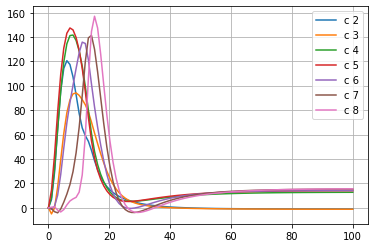

In [60]:
p6data = (patient6, p6_sim, vref6, qref6)

#1
print('Patient 6 s1, and s2')
p6_all_params= blood_8pinn(epochs=20, data = p6data)
p6_all_params.adam_train()

Patient 6 s1, and s2, gamma fit
Epoch 0, training loss: 0.002308891387656331, s1 tensor([1.6089], grad_fn=<AddBackward0>) S2: tensor([1.6275], grad_fn=<MulBackward0>)  Q: tensor([6283.8970], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.0012042587623000145, s1 tensor([1.4968], grad_fn=<AddBackward0>) S2: tensor([1.7099], grad_fn=<MulBackward0>)  Q: tensor([5846.1875], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0009136387379840016, s1 tensor([1.3728], grad_fn=<AddBackward0>) S2: tensor([1.7725], grad_fn=<MulBackward0>)  Q: tensor([5361.5669], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0005962250870652497, s1 tensor([1.2682], grad_fn=<AddBackward0>) S2: tensor([1.8179], grad_fn=<MulBackward0>)  Q: tensor([4953.3086], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0003988241369370371, s1 tensor([1.1986], grad_fn=<AddBackward0>) S2: tensor([1.8492], grad_fn=<MulBackward0>)  Q: tensor([4681.4473], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.00033113581594079733, s

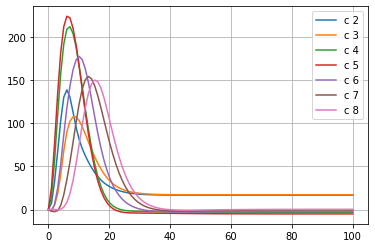

In [61]:
#2
print('Patient 6 s1, and s2, gamma fit')
p6_all_params_gamma = blood_8pinn(epochs=20, data = p6data, gamma=True)
p6_all_params_gamma.adam_train()

Patient 6 s1
Epoch 0, training loss: 0.05915854498744011, s1 tensor([1.]) S2: tensor([1.6220], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 1, training loss: 0.003501704428344965, s1 tensor([1.]) S2: tensor([1.7322], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 2, training loss: 0.0017741272458806634, s1 tensor([1.]) S2: tensor([1.8252], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 3, training loss: 0.0012989526148885489, s1 tensor([1.]) S2: tensor([1.8504], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 4, training loss: 0.0010680676205083728, s1 tensor([1.]) S2: tensor([1.8726], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 5, training loss: 0.0010346485069021583, s1 tensor([1.]) S2: tensor([1.8934], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 6, training loss: 0.0008524556760676205, s1 tensor([1.]) S2: tensor([1.9191], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 7, training loss: 0.0007906982791610062, s1 tensor([1.]) S2:

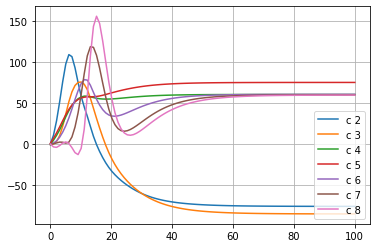

In [62]:
#3
print('Patient 6 s1')
p6_sq = b8_pinn_sQ(epochs=20, data = p6data)
p6_sq.adam_train()

Patient 6 s1, gamma fit
Epoch 0, training loss: 0.0012933316174894571, s1 tensor([1.]) S2: tensor([1.6219], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 1, training loss: 0.0007338579744100571, s1 tensor([1.]) S2: tensor([1.6998], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 2, training loss: 0.0006140782497823238, s1 tensor([1.]) S2: tensor([1.7630], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 3, training loss: 0.0004179014067631215, s1 tensor([1.]) S2: tensor([1.8096], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 4, training loss: 0.0003304460260551423, s1 tensor([1.]) S2: tensor([1.8417], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 5, training loss: 0.0002627801732160151, s1 tensor([1.]) S2: tensor([1.8617], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 6, training loss: 0.0006320358370430768, s1 tensor([1.]) S2: tensor([1.8690], grad_fn=<MulBackward0>)  Q: tensor([3905.6699])
Epoch 7, training loss: 0.00018115249986294657, s1 t

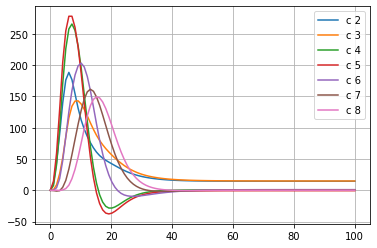

In [63]:
#4
print('Patient 6 s1, gamma fit')
p6_sq_gamma = b8_pinn_sQ(epochs=20, data = p6data, gamma = True)
p6_sq_gamma.adam_train()

Patient 6, s2
Epoch 0, training loss: 0.05688077211380005, s1 tensor([1.6706], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([6524.6919], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.00819498673081398, s1 tensor([1.5486], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([6048.1768], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.003665004391223192, s1 tensor([1.4107], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5509.7896], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.0024760770611464977, s1 tensor([1.3026], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5087.5649], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.002625306136906147, s1 tensor([1.2196], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4763.3086], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.001670476864092052, s1 tensor([1.1573], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4520.0483], grad_fn=<MulBackward0>)
Epoch 6, training loss: 0.0015169428661465645, s1 tensor(

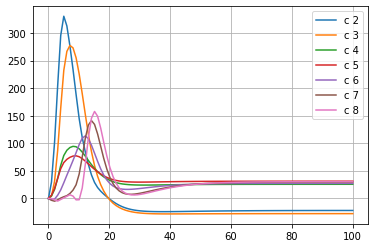

In [64]:
#5
print('Patient 6, s2')
p6_sv = b8_pinn_sV(epochs=20, data = p6data)
p6_sv.adam_train()

patient 6, s2, gamma fit
Epoch 0, training loss: 0.004091063514351845, s1 tensor([1.6619], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([6490.6826], grad_fn=<MulBackward0>)
Epoch 1, training loss: 0.002411170629784465, s1 tensor([1.5514], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([6059.1030], grad_fn=<MulBackward0>)
Epoch 2, training loss: 0.0016024565557017922, s1 tensor([1.4250], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5565.7666], grad_fn=<MulBackward0>)
Epoch 3, training loss: 0.001013831701129675, s1 tensor([1.3146], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([5134.2725], grad_fn=<MulBackward0>)
Epoch 4, training loss: 0.0009569522808305919, s1 tensor([1.2291], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4800.3271], grad_fn=<MulBackward0>)
Epoch 5, training loss: 0.000566503033041954, s1 tensor([1.1642], grad_fn=<AddBackward0>) S2: tensor([1.])  Q: tensor([4546.8877], grad_fn=<MulBackward0>)
Epoch 6, training loss: 0.00049199350178241

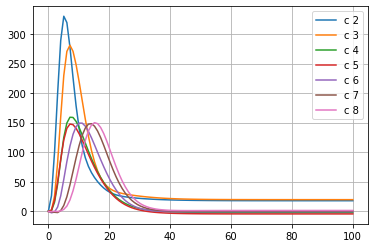

In [65]:
#6
print('patient 6, s2, gamma fit')
p6_sv_gamma = b8_pinn_sV(epochs=20, data = p6data, gamma = True)
p6_sv_gamma.adam_train()

patient 6, no params
Epoch 0, training loss: 0.05843617767095566, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 1, training loss: 0.004525621421635151, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 2, training loss: 0.0018585679354146123, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 3, training loss: 0.0014555897796526551, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 4, training loss: 0.0011770286364480853, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 5, training loss: 0.001008039340376854, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 6, training loss: 0.0009513930417597294, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 7, training loss: 0.0007404325297102332, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 8, training loss: 0.0006762062548659742, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 9, training loss: 0.0011011153692379594, 

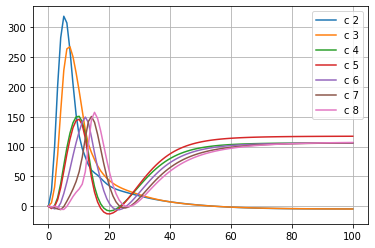

In [66]:
#7
print('patient 6, no params')
p6_none =b8_pinn_noparams(epochs=20, data = p6data)
p6_none.adam_train()

patient 6 , no params, gamma fit
Epoch 0, training loss: 0.003825628664344549, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 1, training loss: 0.00239519658498466, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 2, training loss: 0.0019391973037272692, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 3, training loss: 0.0015584940556436777, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 4, training loss: 0.000991487642750144, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 5, training loss: 0.0008539044065400958, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 6, training loss: 0.0004522347589954734, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 7, training loss: 0.0003721004177350551, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 8, training loss: 0.00029047668795101345, s1 tensor([1.]) S2: tensor([1.])  Q: tensor([3905.6699])
Epoch 9, training loss: 0.00025779

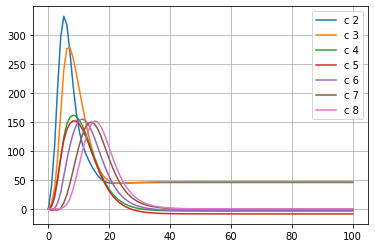

In [67]:
#8
print('patient 6 , no params, gamma fit')
p6_none_gamma = b8_pinn_noparams(epochs=20, data = p6data, gamma=True)
p6_none_gamma.adam_train()